In [95]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", reshape=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [96]:
import numpy as np

In [97]:
import matplotlib.pyplot as plt

In [98]:
learning_rate = 0.001
training_iters =  300
batch_size = 64
display_step = 100

In [99]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.8 # Dropout, probability to keep units

In [100]:
import os
session = tf.Session()
saver = tf.train.Saver()
save_dir = 'checkpoint'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'best_validation')
init = tf.global_variables_initializer()
session.run(init)

try:
    print("trying to restore last checkpoint")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
except:
    # If the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore checkpoint. Initializing variables instead.")
    session.run(tf.global_variables_initializer())

trying to restore last checkpoint
Failed to restore checkpoint. Initializing variables instead.


In [101]:
a = tf.placeholder(tf.float32, (100,28,28,1))
x_image = tf.reshape(a,[-1,28,28,1])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 10)
keep_prob = tf.placeholder(tf.float32)
session.run(tf.global_variables_initializer())


## init alexnet

In [102]:
def conv2d(name, l_input, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b), name=name)

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def alex_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
   # _X = tf.reshape(_X, shape=[-1, 28, 28, 1]) ## we are doing this already, let us try sending 'a' placeholder as an input

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=2)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=2)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=2)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)

    # Fully connected layer
    # Reshape conv3 output to fit dense layer input
    dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]]) ## this is a fully connected layer
    # Relu activation
    dense1 = tf.nn.relu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    
    # Relu activation
    dense2 = tf.nn.relu(tf.matmul(dense1, _weights['wd2']) + _biases['bd2'], name='fc2') 

    # Output, class prediction
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out, conv1, conv2, conv3, dense1, dense2

In [103]:
weights = {
    'wc1': tf.Variable(tf.random_normal([3, 3, 1, 64])),
    'wc2': tf.Variable(tf.random_normal([3, 3, 64, 128])),
    'wc3': tf.Variable(tf.random_normal([3, 3, 128, 256])),
    'wd1': tf.Variable(tf.random_normal([4*4*256, 1024])),
    'wd2': tf.Variable(tf.random_normal([1024, 1024])),
    'out': tf.Variable(tf.random_normal([1024, 10]))
}
biases = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
session.run(tf.global_variables_initializer())

In [104]:
pred, conv1, conv2, conv3, dense1, dense2 = alex_net(x_image, weights, biases, keep_prob)

In [105]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(pred, one_hot_y)

print(cross_entropy)
loss_operation = tf.reduce_mean(cross_entropy)
#print(loss_operation)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)


Tensor("Reshape_16:0", shape=(100,), dtype=float32)


In [106]:
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [107]:
EPOCHS = 1
BATCH_SIZE = 100

## train the model

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(mnist.train.images)
    
    print("Training...")
   # print()
    for i in range(EPOCHS):
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = mnist.train.images[offset:end], mnist.train.labels[offset:end]
            sess.run(training_operation, feed_dict={a: batch_x, y: batch_y, keep_prob:dropout})
            
        #validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        #print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...
EPOCH 1 ...

Model saved


## restore weights

In [61]:
def restoreWeights():
    for wIdx in range(0, len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wOrigConv[wIdx])
        session.run(assign_op)
    
    for wIdx in range(0, len(weightsDenseMat)):
        assign_op = weightsDenseMat[wIdx].assign(wOrigDense[wIdx])
        session.run(assign_op)

In [108]:
restoreWeights()

## store original weights

In [109]:
w1 = weights["wc1"]
w2 = weights["wc2"]
w3 = weights["wc3"]
w4 = weights["wd1"]
w5 = weights["wd2"]
w6 = weights["out"]

wConvOrig1 = session.run(w1)
wConvOrig2 = session.run(w2)
wConvOrig3 = session.run(w3)
wDenseOrig1 = session.run(w4)
wDenseOrig2 = session.run(w5)
wDenseOrig3 = session.run(w6)


In [110]:
wConvOrig3.shape

(3, 3, 128, 256)

In [111]:
wOrigConv = [wConvOrig1, wConvOrig2, wConvOrig3]
wOrigDense = [wDenseOrig1, wDenseOrig2, wDenseOrig3]

In [112]:
wOrigConv[0].shape

(3, 3, 1, 64)

## weightsConvMat and weightsFcMat 

In [113]:
weightsConvMat = [w1, w2, w3]
weightsDenseMat = [w4, w5, w6]
wConv1 = session.run(w1)
wConv2 = session.run(w2)
wConv3 = session.run(w3)
wDense1 = session.run(w4) 
wDense2 = session.run(w5)
wDense3 = session.run(w6)


wConv = [wConv1, wConv2, wConv3]
wDense = [wDense1, wDense2, wDense3]
session.run(tf.global_variables_initializer())

## create a list to hold the difference

In [114]:
wDiffConv = [] + wOrigConv
wDiffDense = [] + wOrigDense

In [115]:
wDiffConv[0].shape

(3, 3, 1, 64)

## create alternative filters

In [116]:
def centroidFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen,2):
                    for k in range(0,ylen,2):
                        first = wtMat[j,k,c,i]
                        if j+1 < xlen:
                            second = wtMat[j+1,k,c,i]
                        else:
                            second = 0
                        if k+1 < xlen:
                            third = wtMat[j,k+1,c,i]
                        else:
                            third = 0
                        if j+1 < xlen and k+1 < ylen:
                            forth = wtMat[j+1,k+1,c,i]
                        else:
                            forth = 0
                        total = 0.0
                        total = float(first + second + third + forth)
                        total /= 4
                        wtMat[j,k,c,i] = total
                        if j+1 < xlen:
                            wtMat[j+1,k,c,i] = total
                        if k+1 < xlen:
                            wtMat[j,k+1,c,i] = total
                        if j+1 < xlen and k+1 < ylen:
                            wtMat[j+1,k+1,c,i] = total
                        #if wtMat[j,k,0,i] < 0:
                        #    wtMat[j,k,0,i] = 0#float('%.5f'%(w[j,k,0,i]))
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                first = wtMat[i,j] 
                second = wtMat[i,j+1]
                avg = (first+second)/2
                wtMat[i,j] = avg
                wtMat[i,j+1] = avg
                j = j+2

In [117]:
def truncateFilter(wtListConv,wtListFc):
    num = len(wtListConv)
    
    
    for wtMat in wtListConv:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        numChnls = shape[2]
        numFilters = shape[3]

        for c in range(0,numChnls):
            for i in range(0,numFilters):
                for j in range(0,xlen):
                    for k in range(0,ylen):
                        wtMat[j,k,c,i] = float('%.5f'%(wtMat[j,k,c,i]))
                        
                        
    for wtMat in wtListFc:
        shape = wtMat.shape
        xlen = shape[0]
        ylen = shape[1]
        
        for i in range(0,xlen):
            j=0
            while j<ylen:
                wtMat[i,j]=float('%.5f'%(wtMat[i,j]))
                j=j+1;

                        

In [118]:
#centroidFilter(wConv, wDense)
truncateFilter(wConv, wDense)

In [119]:
wOrigConv

[array([[[[-1.47125214e-01, -1.37246573e+00,  6.46202028e-01,
            2.28370905e-01,  7.88725447e-03,  8.05711687e-01,
           -3.64584446e-01,  5.83869576e-01,  7.41019189e-01,
           -7.60432124e-01, -2.23120618e+00,  8.54385197e-02,
            2.43809238e-01,  2.95527726e-01, -1.39261961e+00,
           -1.17822516e+00,  4.54264760e-01, -1.01099324e+00,
           -1.94659576e-01,  1.03064492e-01, -1.85848564e-01,
           -1.10025764e+00,  2.21834517e+00, -1.52171361e+00,
            5.78023612e-01,  3.06211542e-02, -1.75857037e-01,
           -1.50481153e+00, -6.94639444e-01, -7.58504868e-01,
            5.51509261e-01,  2.45658493e+00, -8.81307602e-01,
            4.13441136e-02, -1.18224609e+00,  6.91921711e-01,
           -1.33170620e-01,  2.09367013e+00, -7.61444718e-02,
            5.71603835e-01, -9.71799716e-02,  2.47279838e-01,
            1.49442804e+00,  2.96535283e-01, -3.54099758e-02,
            9.24289525e-01, -1.85574427e-01,  4.52271134e-01,
        

In [120]:
wConv

[array([[[[-1.47130e-01, -1.37247e+00,  6.46200e-01,  2.28370e-01,
            7.89000e-03,  8.05710e-01, -3.64580e-01,  5.83870e-01,
            7.41020e-01, -7.60430e-01, -2.23121e+00,  8.54400e-02,
            2.43810e-01,  2.95530e-01, -1.39262e+00, -1.17823e+00,
            4.54260e-01, -1.01099e+00, -1.94660e-01,  1.03060e-01,
           -1.85850e-01, -1.10026e+00,  2.21835e+00, -1.52171e+00,
            5.78020e-01,  3.06200e-02, -1.75860e-01, -1.50481e+00,
           -6.94640e-01, -7.58500e-01,  5.51510e-01,  2.45658e+00,
           -8.81310e-01,  4.13400e-02, -1.18225e+00,  6.91920e-01,
           -1.33170e-01,  2.09367e+00, -7.61400e-02,  5.71600e-01,
           -9.71800e-02,  2.47280e-01,  1.49443e+00,  2.96540e-01,
           -3.54100e-02,  9.24290e-01, -1.85570e-01,  4.52270e-01,
           -1.17560e-01,  9.92600e-02, -5.03160e-01,  4.16960e-01,
           -1.11979e+00,  7.27280e-01,  1.71504e+00, -3.06720e-01,
            1.62304e+00, -8.31860e-01,  7.69890e-01, -1.38780e

## assign filters

In [121]:
def assignFilters(wConv,wFc):
    for wIdx in range(0,len(weightsConvMat)):
        assign_op = weightsConvMat[wIdx].assign(wConv[wIdx])
        session.run(assign_op)
        
    for wIdx in range(0,len(weightsDenseMat)):
        assign_op = weightsDenseMat[wIdx].assign(wFc[wIdx])
        session.run(assign_op)

In [122]:
assignFilters(wConv, wDense)

## static difference

In [123]:
def calculateDiff(wConv, wFc, wOrigConv, wOrigFc):
    for i in range(len(wConv)):
        wDiffConv[i] = abs(wOrigConv[i] - wConv[i])
        
    
            
        
    for i in range(len(wFc)):
        wDiffDense[i] = abs(wOrigFc[i] - wFc[i])
    
    

In [124]:
calculateDiff(wConv, wDense, wOrigConv, wOrigDense)

In [125]:
wDiffConv[0]

array([[[[4.7832727e-06, 4.2915344e-06, 2.0265579e-06, 9.0897083e-07,
          2.7455389e-06, 1.6689301e-06, 4.4405460e-06, 4.1723251e-07,
          8.3446503e-07, 2.1457672e-06, 3.8146973e-06, 1.4826655e-06,
          7.5995922e-07, 2.2649765e-06, 3.5762787e-07, 4.8875809e-06,
          4.7683716e-06, 3.2186508e-06, 4.1723251e-07, 4.4927001e-06,
          1.4305115e-06, 2.3841858e-06, 4.7683716e-06, 3.5762787e-06,
          3.6358833e-06, 1.1548400e-06, 2.9653311e-06, 1.5497208e-06,
          5.3644180e-07, 4.8875809e-06, 7.1525574e-07, 5.0067902e-06,
          2.3841858e-06, 4.1127205e-06, 3.9339066e-06, 1.7285347e-06,
          6.2584877e-07, 2.3841858e-07, 4.4703484e-06, 3.8146973e-06,
          2.9802322e-08, 1.6391277e-07, 1.9073486e-06, 4.7087669e-06,
          2.2351742e-08, 4.7683716e-07, 4.4256449e-06, 1.1324883e-06,
          2.0116568e-06, 3.6284328e-06, 1.1920929e-06, 3.6954880e-06,
          9.5367432e-07, 3.0398369e-06, 8.3446503e-07, 2.4139881e-06,
          1.5497208e

In [229]:
def calculateConvME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            #print(result)
            result_sum = np.sum(result)/numFilters
            means[i] = result_sum/numImg

            
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)
            
            
   
    
   # average = [x/numImg for x in posME]
    averageSorted = np.sort(meanSum)
    return meanSum, averageSorted

In [230]:
def calculateDenseME(valuesMat):
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[1]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    
    for nImg in range(0, numImg):
        meanSum = meanSum + means
        for i in range(0, numFilters):
            result = valMat[nImg, i]
            result_sum = np.sum(result)/numFilters
            means[i] = result_sum
    
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)
    
    
    
    average = [x/numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted

In [222]:
session.run( tf.global_variables_initializer())

In [45]:
def loadValues(numImg):
    images = mnist.train.images[0:numImg]
    #print(images.shape)
    feed_dict = {a: images, keep_prob:dropout}
    values_conv1 = session.run(conv1, feed_dict=feed_dict)
    
    values_conv2 = session.run(conv2, feed_dict=feed_dict)
    values_conv3 = session.run(conv3, feed_dict = feed_dict)
    values_dense1 = session.run(dense1, feed_dict = feed_dict)
    values_dense2 = session.run(dense2, feed_dict = feed_dict)
    values_dense3 = session.run(pred, feed_dict = feed_dict)
    
    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesDenseMat = [values_dense1, values_dense2, values_dense3]
    
    return valuesConvMat, valuesDenseMat, numImg

In [116]:
print(a)
images = mnist.train.images[0:100]
feed_dict = {a: images}
#print(feed_dict)
print(conv2)

Tensor("Placeholder_3:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("conv2:0", shape=(100, 14, 14, 128), dtype=float32)


In [79]:
#valuesConvMat, valuesDenseMat, numImg = loadValues(100)

In [481]:
wDiffDense

[array([[1.1324883e-06, 2.5629997e-06, 2.1606684e-06, ..., 5.0067902e-06,
         3.5762787e-06, 2.3245811e-06],
        [2.2649765e-06, 4.0680170e-06, 2.1457672e-06, ..., 4.1127205e-06,
         2.5629997e-06, 1.0728836e-06],
        [4.7683716e-07, 1.3113022e-06, 4.7683716e-07, ..., 1.1920929e-06,
         5.2712858e-07, 8.9406967e-07],
        ...,
        [4.2915344e-06, 4.7683716e-06, 3.4570694e-06, ..., 7.1525574e-07,
         1.1920929e-07, 4.5299530e-06],
        [1.5497208e-06, 2.8312206e-06, 1.2218952e-06, ..., 7.8603625e-07,
         1.6689301e-06, 5.9604645e-07],
        [3.0547380e-07, 1.2293458e-06, 4.4405460e-06, ..., 9.5367432e-07,
         3.7252903e-06, 4.2915344e-06]], dtype=float32),
 array([[4.0531158e-06, 4.3213367e-06, 4.0829182e-06, ..., 3.5762787e-06,
         9.5367432e-07, 4.6491623e-06],
        [1.6093254e-06, 4.7087669e-06, 5.3644180e-07, ..., 1.7881393e-07,
         4.0531158e-06, 1.7881393e-07],
        [4.5299530e-06, 3.5762787e-07, 3.0994415e-06, ...,

## this is where we begin computation of the ME values

In [154]:
## for the conv layers
numImg = 10000
images = mnist.train.images[0:numImg]

myarray1 = np.array(wDiffConv[0])
myarray2 = np.array(wDiffConv[1])
myarray3 = np.array(wDiffConv[2])
tensor1 = tf.constant(myarray1, shape=[3, 3, 1, 64]) 
tensor2 = tf.constant(myarray2, shape=[3, 3, 64, 128])
tensor3 = tf.constant(myarray3, shape=[3, 3, 128, 256])
feed_dict = {a: images, keep_prob:dropout}
#valuesConv1 = session.run(tensor1, feed_dict = feed_dict)
#valuesConv2 = session.run(tensor2, feed_dict = feed_dict)
#valuesConv3 = session.run(tensor3, feed_dict = feed_dict)

## for the dense layers

myarray4 = np.array(wDiffDense[0])
myarray5 = np.array(wDiffDense[1])
myarray6 = np.array(wDiffDense[2])
tensor4 = tf.constant(myarray4, shape=[4096, 1024]) 
tensor5= tf.constant(myarray5, shape=[1024, 1024])
tensor6 = tf.constant(myarray6, shape=[1024, 10])
#valuesDense1 = session.run(tensor3, feed_dict = feed_dict)
#valuesDense2 = session.run(tensor4, feed_dict = feed_dict)
#valuesDense3 = session.run(tensor5, feed_dict = feed_dict)


In [169]:
w1New = weightsModified["wc1"]

wConv1New = session.run(w1New)
wConv1New

array([[[[4.7832727e-06, 4.2915344e-06, 2.0265579e-06, 9.0897083e-07,
          2.7455389e-06, 1.6689301e-06, 4.4405460e-06, 4.1723251e-07,
          8.3446503e-07, 2.1457672e-06, 3.8146973e-06, 1.4826655e-06,
          7.5995922e-07, 2.2649765e-06, 3.5762787e-07, 4.8875809e-06,
          4.7683716e-06, 3.2186508e-06, 4.1723251e-07, 4.4927001e-06,
          1.4305115e-06, 2.3841858e-06, 4.7683716e-06, 3.5762787e-06,
          3.6358833e-06, 1.1548400e-06, 2.9653311e-06, 1.5497208e-06,
          5.3644180e-07, 4.8875809e-06, 7.1525574e-07, 5.0067902e-06,
          2.3841858e-06, 4.1127205e-06, 3.9339066e-06, 1.7285347e-06,
          6.2584877e-07, 2.3841858e-07, 4.4703484e-06, 3.8146973e-06,
          2.9802322e-08, 1.6391277e-07, 1.9073486e-06, 4.7087669e-06,
          2.2351742e-08, 4.7683716e-07, 4.4256449e-06, 1.1324883e-06,
          2.0116568e-06, 3.6284328e-06, 1.1920929e-06, 3.6954880e-06,
          9.5367432e-07, 3.0398369e-06, 8.3446503e-07, 2.4139881e-06,
          1.5497208e

In [128]:
weightsModified = {
    'wc1': tensor1,
    'wc2': tensor2,
    'wc3': tensor3,
    'wd1': tensor4,
    'wd2': tensor5,
    'out': tensor6
}
biasesModified = {
    'bc1': tf.Variable(tf.random_normal([64])),
    'bc2': tf.Variable(tf.random_normal([128])),
    'bc3': tf.Variable(tf.random_normal([256])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}
session.run(tf.global_variables_initializer())


In [129]:
predNew, conv1New, conv2New, conv3New, dense1New, dense2New = alex_net(x_image, weightsModified, biasesModified, keep_prob)

In [130]:
def loadValues2(numImg):
    images = mnist.train.images[0:numImg]
    #print(images.shape)
    feed_dict = {a: images, keep_prob:dropout}
    values_conv1 = session.run(conv1New, feed_dict=feed_dict)
    
    values_conv2 = session.run(conv2New, feed_dict=feed_dict)
    values_conv3 = session.run(conv3New, feed_dict = feed_dict)
    values_dense1 = session.run(dense1New, feed_dict = feed_dict)
    values_dense2 = session.run(dense2New, feed_dict = feed_dict)
    values_dense3 = session.run(predNew, feed_dict = feed_dict)
    
    valuesConvMat = [values_conv1, values_conv2, values_conv3]
    valuesDenseMat = [values_dense1, values_dense2, values_dense3]
    
    return valuesConvMat, valuesDenseMat, numImg

In [158]:
valuesConvMat, valuesDenseMat, numImg = loadValues2(100)

In [171]:
valuesConvMat[0].shape

(100, 28, 28, 64)

In [201]:
means

array([0.18944382, 0.        , 0.        , 0.        , 0.        ,
       0.03343671, 0.        , 0.18823565, 0.11197182, 0.        ,
       0.        , 0.        , 0.0450363 , 0.04183824, 0.0369565 ,
       0.        , 0.06467905, 0.05380147, 0.        , 0.13746033,
       0.        , 0.15624069, 0.        , 0.02097439, 0.08372869,
       0.00468868, 0.25247578, 0.        , 0.        , 0.06288166,
       0.00322898, 0.        , 0.        , 0.        , 0.01343332,
       0.        , 0.160366  , 0.        , 0.04991394, 0.        ,
       0.        , 0.        , 0.        , 0.07136623, 0.00702158,
       0.19033493, 0.07249038, 0.03650416, 0.        , 0.05340206,
       0.        , 0.02749553, 0.        , 0.11966481, 0.        ,
       0.06032189, 0.08032545, 0.        , 0.26907047, 0.        ,
       0.        , 0.12081013, 0.        , 0.12032381])

In [234]:
def convME(valuesMat):
    #valuesMat = valuesConvMat[0]
    shape = valuesMat.shape
    valMat = valuesMat
    numFilters = shape[3]
    means = np.zeros(numFilters)
    meanSum = np.zeros(numFilters)
    for nImg in range(0,numImg):
        meanSum = meanSum + means
        for i in range(0,numFilters):
            result = valMat[nImg,:,:,i]
            #print(result)
            result_sum = np.sum(result)/numFilters
            means[i] = result_sum/numImg
    posME = []
    for sort in meanSum:
        if sort<0:
            sort = sort * -1
            posME.append(sort)
        else :
            posME.append(sort)    
    average = [x/numImg for x in posME]
    averageSorted = np.sort(average)
    return average, averageSorted

In [215]:
average

[0.18754926280975334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.03310225265026092,
 0.0,
 0.18635316543579097,
 0.11085199470520023,
 0.0,
 0.0,
 0.0,
 0.04458585891723634,
 0.04141971707344056,
 0.03658682754039764,
 0.0,
 0.06403211941719056,
 0.05326328516006468,
 0.0,
 0.13608559236526493,
 0.0,
 0.15467814502716062,
 0.0,
 0.020764460372924804,
 0.0828912476539612,
 0.0046416866570711144,
 0.24995091056823732,
 0.0,
 0.0,
 0.06225272154808045,
 0.0031965639442205424,
 0.0,
 0.0,
 0.0,
 0.01329885847568512,
 0.0,
 0.15876223087310795,
 0.0,
 0.04941464438438415,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07065242404937742,
 0.006951254665851593,
 0.18843150959014895,
 0.07176537685394288,
 0.036138988184928895,
 0.0,
 0.05286792569160462,
 0.0,
 0.027220446777343744,
 0.0,
 0.11846803379058837,
 0.0,
 0.059718533372879044,
 0.07952209072113037,
 0.0,
 0.2663796293258666,
 0.0,
 0.0,
 0.11960186958312992,
 0.0,
 0.11912042980194093]

In [235]:
MEConv1, MEConv1Sorted = convME(valuesConvMat[0])
MEDense1, MEDense1Sorted = calculateDenseME(valuesDenseMat[0])
MEConv2, MEConv2Sorted = convME(valuesConvMat[1])
MEDense2, MEDense2Sorted = calculateDenseME(valuesDenseMat[1])
MEConv3, MEConv3Sorted = convME(valuesConvMat[2])
MEDense3, MEDense3Sorted = calculateDenseME(valuesDenseMat[2])

In [236]:
MEConv1

[0.18754926280975334,
 0.0,
 0.0,
 0.0,
 0.0,
 0.03310225265026092,
 0.0,
 0.18635316543579097,
 0.11085199470520023,
 0.0,
 0.0,
 0.0,
 0.04458585891723634,
 0.04141971707344056,
 0.03658682754039764,
 0.0,
 0.06403211941719056,
 0.05326328516006468,
 0.0,
 0.13608559236526493,
 0.0,
 0.15467814502716062,
 0.0,
 0.020764460372924804,
 0.0828912476539612,
 0.0046416866570711144,
 0.24995091056823732,
 0.0,
 0.0,
 0.06225272154808045,
 0.0031965639442205424,
 0.0,
 0.0,
 0.0,
 0.01329885847568512,
 0.0,
 0.15876223087310795,
 0.0,
 0.04941464438438415,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07065242404937742,
 0.006951254665851593,
 0.18843150959014895,
 0.07176537685394288,
 0.036138988184928895,
 0.0,
 0.05286792569160462,
 0.0,
 0.027220446777343744,
 0.0,
 0.11846803379058837,
 0.0,
 0.059718533372879044,
 0.07952209072113037,
 0.0,
 0.2663796293258666,
 0.0,
 0.0,
 0.11960186958312992,
 0.0,
 0.11912042980194093]

## run only once for the OG filters

In [207]:
MEConv1Original = MEConv1
MEConv2Original = MEConv2
MEConv3Original = MEConv3

MEDense1Original = MEDense1
MEDense2Original = MEDense2
MEDense3Original = MEDense3



In [208]:
MEDiff1 = [] + MEConv1
MEDiff2 = [] + MEConv2
MEDiff3 = [] + MEConv3
MEDiff4 = [] + MEDense1
MEDiff5 = [] + MEDense2
MEDiff6 = [] + MEDense3



In [209]:
for i in range(len(MEConv1Original)):
    MEDiff1[i] = abs(MEConv1Original[i] - MEConv1[i])
for i in range(len(MEConv2Original)):
    MEDiff2[i] = abs(MEConv2Original[i] - MEConv2[i])
for i in range(len(MEConv3Original)):
    MEDiff3[i] = abs(MEConv3Original[i] - MEConv3[i])
    
for i in range(len(MEDense1Original)):
    MEDiff4[i] = abs(MEDense1Original[i] - MEDense1[i])
for i in range(len(MEDense2Original)):
    MEDiff5[i] = abs(MEDense2Original[i] - MEDense2[i])
for i in range(len(MEDense3Original)):
    MEDiff6[i] = abs(MEDense3Original[i] - MEDense3[i])

In [140]:
MEDiff1Sorted = np.sort(MEDiff1)
MEDiff2Sorted = np.sort(MEDiff2)
MEDiff3Sorted = np.sort(MEDiff3)
MEDiff4Sorted = np.sort(MEDiff4)
MEDiff5Sorted = np.sort(MEDiff5)
MEDiff6Sorted = np.sort(MEDiff6)


In [166]:
MEConv1Original

[482.96416442871094,
 1631.1949145507813,
 0.0,
 0.0,
 914.9364404296875,
 0.0,
 0.0,
 511.76842712402345,
 0.0,
 0.0,
 1431.47232421875,
 0.0,
 1068.8033715820313,
 1584.0169189453125,
 735.0814050292969,
 338.0358142089844,
 0.0,
 108.91000030517579,
 0.0,
 4.290002517700195,
 892.8708728027344,
 577.3816076660156,
 0.0,
 0.0,
 720.2015551757812,
 0.0,
 0.0,
 0.0,
 953.0733142089844,
 680.3345983886719,
 0.0,
 546.7633923339844,
 1320.6747436523438,
 0.0,
 121.9046566772461,
 175.45774108886718,
 0.0,
 245.48564849853517,
 0.0,
 950.2827758789062,
 0.0,
 0.0,
 0.0,
 864.263232421875,
 811.0063806152343,
 0.0,
 381.93975219726565,
 205.46784118652343,
 0.0,
 264.5917602539063,
 0.0,
 445.40833557128906,
 0.0,
 387.36728942871093,
 0.0,
 438.9720666503906,
 646.049443359375,
 0.0,
 0.0,
 0.0,
 200.25555221557616,
 0.0,
 0.0,
 902.0759875488282]

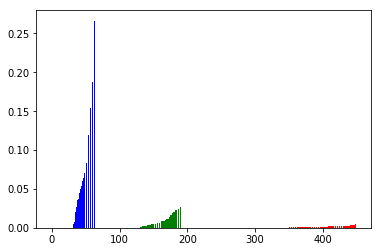

In [237]:
plotConvME(MEConv1Sorted, MEConv2Sorted, MEConv3Sorted)


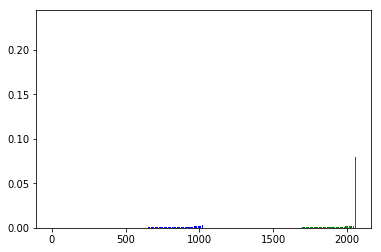

In [238]:
plotDenseME(MEDense1Sorted, MEDense2Sorted, MEDense3Sorted)

In [145]:
MEDiff4Sorted

array([0.        , 0.        , 0.        , ..., 2.72678686, 2.8068627 ,
       2.8107809 ])

In [137]:
for i in range(len(wDiffDense)):
    print(wDiffDense[i].shape)

(4096, 1024)
(1024, 1024)
(1024, 10)


In [183]:
print(len(wDiffConv))

3


## use the difference to find ME

In [92]:
def plotDenseME(ME1, ME2, ME3):
    #import numpy as np
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')

In [93]:
def plotConvME(ME1, ME2, ME3):
    x1 = np.arange(len(ME1))
    x2 = np.arange(len(ME2))
    x3 = np.arange(len(ME3))
    
    plt.bar(x1, ME1, color = 'b', align = 'center')
    d1=  len(ME1) + 1
    plt.bar(x2+d1, ME2, color = 'g', align = 'center')
    d2 = d1 + len(ME2) + 1
    #location = x2 + len(ME1) 
    plt.bar(x3+d2, ME3, color = 'r', align = 'center')